# Housing Price Prediction Model Development

This notebook contains scripts for the development of a xgboost model to predict house prices in DFW area. This model is developed undergoing five important steps. 

* Data extraction via webscraping
* Data cleaning and sanitizing
* Data preprocessing
* Feature engineering
* Model training and validation

In [1]:
# installing required packages 
!pip install beautifulsoup4
!pip install xgboost
!pip install pandas
!pip install geopy
!pip install googlemaps

In [2]:
# importing packages
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
import pandas as pd
from geopy.geocoders import GoogleV3
import geopy.distance
import googlemaps
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
import googlemaps
import requests
from bs4 import BeautifulSoup
from geopy.distance import geodesic as GD
from sklearn.preprocessing import LabelEncoder
import pickle


# Step 1: Data extraction via webscraping

In [3]:
# defining header parameter
head = {
  'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.84 Safari/537.36',
  'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
  'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
  'Accept-Encoding': 'none',
  'Accept-Language': 'en-US,en;q=0.8',
  'Connection': 'keep-alive',
  'refere': 'https://example.com',
  'cookie': """your cookie value ( you can get that from your web page) """
}

# func to scrape housing features from trillow.com
def scrape_housing_data(place -> str, head -> dict):
    
    """scrape housing features from trillow.com.

        This function uses request and beautifulsoap functionalities to scrapre housing
        data from trillow.com

        Parameters
        ----------
        place : str
            city name for which webscraping is to be performed.

        Returns
        -------
        dataframe : pd.DataFrame
            a pandas dataframe with following structure
            pricing address bath bed size
            ------- ------- ---- --- ----

        """
    
    
    dictlist=list()
    obj={}

    import time
    for page in range(0,50):

        resp = requests.get(f"https://www.trulia.com/TX/{place}/{page}_p", headers=head)

        if resp.status_code != 200:
            continue

        soup = BeautifulSoup(resp.content, "html.parser")

        properties = soup.find_all("li", {"class" : "Grid__CellBox-sc-6b10767f-0 sc-fc01d244-0 fhkpkF kAfNFl"})


        for i in range(0,len(properties)):
            try:
                obj["pricing"]=properties[i].find('div', {'data-testid':'property-price'}).text
            except:
                obj["pricing"]=None
            try:
                obj["address"]=properties[i].find("div", {"data-testid": "property-address"}).text
            except:
                obj["address"]=None    
            try:
                obj["bath"]=properties[i].find("div",{"data-testid": "property-baths"}).text
            except:
                obj["bath"]=None         
            try:
                obj["bed"]=properties[i].find("div",{"data-testid": "property-beds"}).text
            except:
                obj["bed"]=None 
            try:
                obj["size"]=properties[i].find("div",{"data-testid": "property-floorSpace"}).text
            except:
                obj["size"]=None 
            dictlist.append(obj)
            obj={}
        
        time.sleep(1)
    dataframe = pd.DataFrame(dictlist).dropna().drop_duplicates()
    print(dictlist)
    return dataframe
        


In [4]:
# scraping data for various places using a function defined above
dallas = scrape_housing_data('Dallas',head)
irving = scrape_housing_data('Irving',head)
grape = scrape_housing_data('Grapevine',head)
euless = scrape_housing_data('Euless',head)
arling = scrape_housing_data('Arlington',head)
fort = scrape_housing_data('Fort_Worth',head)
plano = scrape_housing_data('plano',head)
frisco = scrape_housing_data('frisco',head)
garland = scrape_housing_data('Garland',head)
gp = scrape_housing_data('Grand_Prairie',head)

In [5]:
# concatenating the dataframes for all of the places to create one single dataframe
df_m = pd.concat([dallas.reset_index(), irving.reset_index(), euless.reset_index(),
                  grape.reset_index(), fort.reset_index(), plano.reset_index(),
                 frisco.reset_index(), gp.reset_index(), garland.reset_index()],
                 axis=0)
df_m = df_m.drop_duplicates('address')
df_m

,index,pricing,address,bath,bed,size
0,0,"$724,000","508 S Brighton Ave, Dallas, TX 75208",5ba,5bd,"4,006 sqft"
1,1,"$1,396,000","4726 Hopkins Ave, Dallas, TX 75209",5ba,5bd,"4,001 sqft"
2,4,"$359,000","2519 E Overton Rd, Dallas, TX 75216",2ba,4bd,"1,934 sqft"
3,5,"$589,000","7209 Rutgers Dr, Dallas, TX 75214",2ba,3bd,"1,620 sqft"
4,6,"$1,850,000","4807 W University Blvd, Dallas, TX 75209",7ba,5bd,"4,253 sqft"
...,...,...,...,...,...,...
65,426,"$340,000","4417 Clemson Dr, Garland, TX 75042",2ba,4bd,"2,019 sqft"
66,428,"$564,990","2714 Geranium Ln, Garland, TX 75042",3ba,4bd,"2,768 sqft"
67,434,"$752,895","1819 Emerald Vista Blvd, Wylie, TX 75098",4ba,4bd,"3,487 sqft"
72,439,"$576,000","313 E Spring Valley Rd, Richardson, TX 75081",2ba,6bd,"1,694 sqft (on 0.41 acres)"


### In addition to scraping housing data, the goal was to scrape these three info using google API
* Distance to supermarket
* Distance to school
* Distance to park
* Distance to hospital

This was completed into two steps:
* Task 1: Convert the address into lat long
* Task 2: Use google api to perform search query using lat long

### Task 1: Convert the address into lat long

In [6]:
#'apiconfig.txt' file is deleted for security purpose when submiting this notebook
apikey = open('apiconfig.txt', 'r').read().strip()
geolocator = GoogleV3(api_key=apikey)
client = googlemaps.Client(key = apikey)

In [7]:
def geocode_latlong(df):
    
    """
        This function finds lat and long for a give address in the dataframe and append the results as new columns

        Parameters
        ----------
        df : pd.DataFrame
            pandas dataframe containing address column

        Returns
        -------
        dataframe : pd.DataFrame
            a pandas dataframe two more columns 'latitude' and 'longitude' added

        """
    
    df['latitude'] = ""
    df['longitude'] = ""

    for id, row in df.iterrows():
        try:
            df['latitude'][id] =  geolocator.geocode(row.address).latitude
            df['longitude'][id] =  geolocator.geocode(row.address).longitude
        except:
            df['latitude'][id] = None
            df['longitude'][id] = None
        
    return df

In [8]:
df_m = geocode_latlong(df_m)
df_m


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/835135590.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude'][id] =  geolocator.geocode(row.address).latitude
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/835135590.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude'][id] =  geolocator.geocode(row.address).longitude
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/835135590.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,index,pricing,address,bath,bed,size,latitude,longitude
0,0,"$724,000","508 S Brighton Ave, Dallas, TX 75208",5ba,5bd,"4,006 sqft",32.926293,-96.684597
1,1,"$1,396,000","4726 Hopkins Ave, Dallas, TX 75209",5ba,5bd,"4,001 sqft",32.889537,-96.613278
2,4,"$359,000","2519 E Overton Rd, Dallas, TX 75216",2ba,4bd,"1,934 sqft",32.92941,-96.604515
3,5,"$589,000","7209 Rutgers Dr, Dallas, TX 75214",2ba,3bd,"1,620 sqft",32.905628,-96.623433
4,6,"$1,850,000","4807 W University Blvd, Dallas, TX 75209",7ba,5bd,"4,253 sqft",32.905471,-96.619538
...,...,...,...,...,...,...,...,...
65,426,"$340,000","4417 Clemson Dr, Garland, TX 75042",2ba,4bd,"2,019 sqft",32.923734,-96.699408
66,428,"$564,990","2714 Geranium Ln, Garland, TX 75042",3ba,4bd,"2,768 sqft",32.924019,-96.670001
67,434,"$752,895","1819 Emerald Vista Blvd, Wylie, TX 75098",4ba,4bd,"3,487 sqft",32.992343,-96.541001
72,439,"$576,000","313 E Spring Valley Rd, Richardson, TX 75081",2ba,6bd,"1,694 sqft (on 0.41 acres)",32.940341,-96.73215


### Task 2: Use google api to perform search query using lat long

In [9]:
def find_distance(location ->tuple, radius->int, keyword->str):
        
        """
        This function uses lat and long to find desired places (defined by keyword) within the user-defined radius. 
        First it list out the places meeting the radious constraint and calculates the distance between the give lat/long to 
        lat/long of the listed places using package GD. Second, it finds and returns the minimum distance.

        Parameters
        ----------
        location : tuple 
            tuple of latitude and longitude e.g. (-33.24, 104.44)
        radius : int
            radius of the search in meters e.g. 20000
        keyword: str
            place type e.g. supermarket

        Returns
        -------
        float value for the minimum distance
            
        """
    
    res=client.places_nearby(location, radius=radius, keyword=keyword)
    dislist = [GD ( (item['geometry']['location']['lat'], item['geometry']['location']['lng']), location).miles for item in res['results']]
    return round(np.min(dislist, axis=0), 2)
    

In [10]:
def calculate_dis(df1):
    
            
        """
        This function iterates over all pairs of lat and long and implements 'find_distance' func to calculate minimum
        distance. It does so for school, hospital, supermarket, and park

        Parameters
        ----------
        df1: pd.DataFrame
        a pandas dataframe containing pairs of lat and long

        Returns
        -------
        df1: pd.DataFrame
        a pandas dataframe with four new columns added to it (shown below)
        'dis_to_school'
        'dis_to_hospital'
        'dis_to_supermarket'
        'dis_to_park'
            
        """
        
    df1['dis_to_school']= ""
    df1['dis_to_hospital']= ""
    df1['dis_to_supermarket']= ""
    df1['dis_to_park']= ""


    for id, row in df1.iterrows():
        try:
            df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
        except:
            df1['dis_to_school'][id] = None
        try:
            df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
        except:
            df1['dis_to_hospital'][id] = None
        try:
            df1['dis_to_supermarket'][id] = find_distance((row.latitude, row.longitude), 20000, 'supermarket')
        except:
            df1['dis_to_supermarket'][id] = None

        try:
            df1['dis_to_park'][id] = find_distance((row.latitude, row.longitude), 20000, 'park')
        except:
            df1['dis_to_park'][id] = None
            
        if id%100==0:
            print(id)
    return df1

In [11]:
# implementing "calculate_dis" function
df_m1 = calculate_dis(df_m)
df_m1

/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

100


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

100


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

0


/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_school'][id] = find_distance((row.latitude, row.longitude), 20000, 'school')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dis_to_hospital'][id] = find_distance((row.latitude, row.longitude), 20000, 'hospital')
/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/3650295453.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

,index,pricing,address,bath,bed,size,latitude,longitude,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park
0,0,"$724,000","508 S Brighton Ave, Dallas, TX 75208",5ba,5bd,"4,006 sqft",32.926293,-96.684597,0.93,4.9,1.46,1.84
1,1,"$1,396,000","4726 Hopkins Ave, Dallas, TX 75209",5ba,5bd,"4,001 sqft",32.889537,-96.613278,2.17,6.39,1.77,1.96
2,4,"$359,000","2519 E Overton Rd, Dallas, TX 75216",2ba,4bd,"1,934 sqft",32.92941,-96.604515,1.57,5.62,2.46,1.57
3,5,"$589,000","7209 Rutgers Dr, Dallas, TX 75214",2ba,3bd,"1,620 sqft",32.905628,-96.623433,2.18,5.67,0.76,5.33
4,6,"$1,850,000","4807 W University Blvd, Dallas, TX 75209",7ba,5bd,"4,253 sqft",32.905471,-96.619538,2.19,5.89,0.99,1.74
...,...,...,...,...,...,...,...,...,...,...,...,...
65,426,"$340,000","4417 Clemson Dr, Garland, TX 75042",2ba,4bd,"2,019 sqft",32.923734,-96.699408,1.18,4.37,1.96,1.84
66,428,"$564,990","2714 Geranium Ln, Garland, TX 75042",3ba,4bd,"2,768 sqft",32.924019,-96.670001,0.93,4.96,1.7,2.45
67,434,"$752,895","1819 Emerald Vista Blvd, Wylie, TX 75098",4ba,4bd,"3,487 sqft",32.992343,-96.541001,4.85,3.61,4.94,6.34
72,439,"$576,000","313 E Spring Valley Rd, Richardson, TX 75081",2ba,6bd,"1,694 sqft (on 0.41 acres)",32.940341,-96.73215,2.45,3.09,0.53,1.06


# Step 2: Data cleaning and sanitizing
In this step, four important tasks were carried out
* Task 1: Clean dataset and format datatypes
* Task 2: Add new columns(features)
* Task 3: Add missing values to the dataset (simulate)
* Task 4: Impute missing values

### Task 1: Clean dataset and format datatypes

In [12]:
# getting rid of unnecessary columns
raw_features = df_m1.drop(['index','address', 'latitude', 'longitude' ], axis=1)
raw_features

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park
0,"$724,000",5ba,5bd,"4,006 sqft",0.93,4.9,1.46,1.84
1,"$1,396,000",5ba,5bd,"4,001 sqft",2.17,6.39,1.77,1.96
2,"$359,000",2ba,4bd,"1,934 sqft",1.57,5.62,2.46,1.57
3,"$589,000",2ba,3bd,"1,620 sqft",2.18,5.67,0.76,5.33
4,"$1,850,000",7ba,5bd,"4,253 sqft",2.19,5.89,0.99,1.74
...,...,...,...,...,...,...,...,...
65,"$340,000",2ba,4bd,"2,019 sqft",1.18,4.37,1.96,1.84
66,"$564,990",3ba,4bd,"2,768 sqft",0.93,4.96,1.7,2.45
67,"$752,895",4ba,4bd,"3,487 sqft",4.85,3.61,4.94,6.34
72,"$576,000",2ba,6bd,"1,694 sqft (on 0.41 acres)",2.45,3.09,0.53,1.06


In [13]:
# removing $ and comma from "pricing"
# extracting only digits from "bath" and "bed"

for col in ['pricing', 'bed', 'bath']:
    raw_features[col] = raw_features[col].apply(lambda x: int(''.join([n for n in x if n.isdigit()])) if x!= 'Studio' else 1 )

    
# extracting only digits pertaining to sqft from "size"
raw_features['size']= raw_features['size'].apply(lambda x: int([l for l in re.findall(r'[\d,]+[,\d]', x)][0].replace(",", "")))
raw_features
    

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park
0,724000,5,5,4006,0.93,4.9,1.46,1.84
1,1396000,5,5,4001,2.17,6.39,1.77,1.96
2,359000,2,4,1934,1.57,5.62,2.46,1.57
3,589000,2,3,1620,2.18,5.67,0.76,5.33
4,1850000,7,5,4253,2.19,5.89,0.99,1.74
...,...,...,...,...,...,...,...,...
65,340000,2,4,2019,1.18,4.37,1.96,1.84
66,564990,3,4,2768,0.93,4.96,1.7,2.45
67,752895,4,4,3487,4.85,3.61,4.94,6.34
72,576000,2,6,1694,2.45,3.09,0.53,1.06


In [14]:
raw_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 73
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   pricing             709 non-null    int64 
 1   bath                709 non-null    int64 
 2   bed                 709 non-null    int64 
 3   size                709 non-null    int64 
 4   dis_to_school       709 non-null    object
 5   dis_to_hospital     709 non-null    object
 6   dis_to_supermarket  709 non-null    object
 7   dis_to_park         709 non-null    object
dtypes: int64(4), object(4)
memory usage: 66.0+ KB


In [15]:
# info() showed that datatype of dis_* columns was object. So converting them to 'float' dtype

for col in raw_features.columns.tolist()[4:]:
    raw_features[col] = raw_features[col].astype('float')
raw_features

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park
0,724000,5,5,4006,0.93,4.90,1.46,1.84
1,1396000,5,5,4001,2.17,6.39,1.77,1.96
2,359000,2,4,1934,1.57,5.62,2.46,1.57
3,589000,2,3,1620,2.18,5.67,0.76,5.33
4,1850000,7,5,4253,2.19,5.89,0.99,1.74
...,...,...,...,...,...,...,...,...
65,340000,2,4,2019,1.18,4.37,1.96,1.84
66,564990,3,4,2768,0.93,4.96,1.70,2.45
67,752895,4,4,3487,4.85,3.61,4.94,6.34
72,576000,2,6,1694,2.45,3.09,0.53,1.06


### Task 2: Add new columns (features)

In [16]:
# As suggested in the assignment, presence of amenities was deemed as important features. However, these info couldn't
# web-scraped from trillow.com due to various reasons. So, a rule-based threshold scheme was defined to impute these info
# based on "size"

feature_df = raw_features.copy()
feature_df['isPool'] = feature_df['size'].apply(lambda x: True if x >5000 else False)
feature_df['isBackyard'] = feature_df['size'].apply(lambda x: True if x >3000 else False)
feature_df['isGarage'] = feature_df['size'].apply(lambda x: True if x >2000 else False)
feature_df

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park,isPool,isBackyard,isGarage
0,724000,5,5,4006,0.93,4.90,1.46,1.84,False,True,True
1,1396000,5,5,4001,2.17,6.39,1.77,1.96,False,True,True
2,359000,2,4,1934,1.57,5.62,2.46,1.57,False,False,False
3,589000,2,3,1620,2.18,5.67,0.76,5.33,False,False,False
4,1850000,7,5,4253,2.19,5.89,0.99,1.74,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
65,340000,2,4,2019,1.18,4.37,1.96,1.84,False,False,True
66,564990,3,4,2768,0.93,4.96,1.70,2.45,False,False,True
67,752895,4,4,3487,4.85,3.61,4.94,6.34,False,True,True
72,576000,2,6,1694,2.45,3.09,0.53,1.06,False,False,False


In [17]:
# saving the dataframe
feature_df.to_csv("dfw_housing_dataset.csv")

In [18]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 73
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pricing             709 non-null    int64  
 1   bath                709 non-null    int64  
 2   bed                 709 non-null    int64  
 3   size                709 non-null    int64  
 4   dis_to_school       709 non-null    float64
 5   dis_to_hospital     709 non-null    float64
 6   dis_to_supermarket  709 non-null    float64
 7   dis_to_park         709 non-null    float64
 8   isPool              709 non-null    bool   
 9   isBackyard          709 non-null    bool   
 10  isGarage            709 non-null    bool   
dtypes: bool(3), float64(4), int64(4)
memory usage: 68.1 KB


In [19]:
feature_df.isnull().sum()

pricing               0
bath                  0
bed                   0
size                  0
dis_to_school         0
dis_to_hospital       0
dis_to_supermarket    0
dis_to_park           0
isPool                0
isBackyard            0
isGarage              0
dtype: int64

### Task 3: Add missing values to the dataset (simulate)

In [20]:
#introducing null values to all of the independent variables randomly
feature_df_missing = feature_df.copy()
for col in feature_df_missing.columns:
    if col!='pricing':
        feature_df_missing.loc[feature_df_missing.index.isin(random.randint(feature_df.shape[0]-1, size=(random.randint(10, 50)))), col] = np.nan
    

In [21]:
feature_df_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 73
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pricing             709 non-null    int64  
 1   bath                658 non-null    float64
 2   bed                 685 non-null    float64
 3   size                697 non-null    float64
 4   dis_to_school       702 non-null    float64
 5   dis_to_hospital     665 non-null    float64
 6   dis_to_supermarket  686 non-null    float64
 7   dis_to_park         668 non-null    float64
 8   isPool              692 non-null    object 
 9   isBackyard          644 non-null    object 
 10  isGarage            699 non-null    object 
dtypes: float64(7), int64(1), object(3)
memory usage: 82.6+ KB


In [22]:
feature_df_missing.isnull().sum()

pricing                0
bath                  51
bed                   24
size                  12
dis_to_school          7
dis_to_hospital       44
dis_to_supermarket    23
dis_to_park           41
isPool                17
isBackyard            65
isGarage              10
dtype: int64

### Task 4: Impute missing values
We now have a mixed dataset with 7 numerical and 3 boolean independent varaibles. They required different imputation
strategy


In [23]:
# grouping column names for easy referencing later
boolcols = [col for col in feature_df.columns if feature_df[col].dtype=='bool']
numericalcols = [col for col in feature_df.columns if feature_df[col].dtype!='bool']
intcols = [col for col in feature_df.columns if feature_df[col].dtype=='int64']

In [24]:
#using simpleImputer
from sklearn.impute import SimpleImputer
bool_imputed= SimpleImputer(strategy="most_frequent").fit_transform(feature_df_missing[boolcols])
numerical_imputed= SimpleImputer(strategy="mean").fit_transform(feature_df_missing[numericalcols])


In [25]:
############## For numerical columns ###############

# Imputing values using a imputer function called iterativeImputer. 
# Multivariate imputer that estimates each feature from all the others. 
# For more info: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(feature_df_missing[numericalcols])
numerical_imputed=imp.transform(feature_df_missing[numericalcols])

############## For boolean columns ###############

# Imputing values using a imputer function called SimpleImputer. 
# Univariate imputer for completing missing values with simple strategies.
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.impute import SimpleImputer
bool_imputed= SimpleImputer(strategy="most_frequent").fit_transform(feature_df_missing[boolcols])


In [26]:
bool_imputed, numerical_imputed

(array([[False, True, True],
        [False, True, True],
        [False, False, False],
        ...,
        [False, True, True],
        [False, False, False],
        [False, True, True]], dtype=object),
 array([[7.24000e+05, 5.00000e+00, 5.00000e+00, ..., 4.90000e+00,
         1.46000e+00, 1.84000e+00],
        [1.39600e+06, 5.00000e+00, 5.00000e+00, ..., 6.39000e+00,
         1.77000e+00, 1.96000e+00],
        [3.59000e+05, 2.00000e+00, 4.00000e+00, ..., 5.62000e+00,
         2.46000e+00, 1.57000e+00],
        ...,
        [7.52895e+05, 4.00000e+00, 4.00000e+00, ..., 3.61000e+00,
         4.94000e+00, 6.34000e+00],
        [5.76000e+05, 2.00000e+00, 6.00000e+00, ..., 3.09000e+00,
         5.30000e-01, 1.06000e+00],
        [9.24999e+05, 4.00000e+00, 4.00000e+00, ..., 3.29000e+00,
         5.65000e+00, 5.68000e+00]]))

In [27]:
# assigning the imputed values to respective variables
feature_df_imp = feature_df_missing.copy()
feature_df_imp[boolcols]= bool_imputed
feature_df_imp[numericalcols]= numerical_imputed
feature_df_imp


,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park,isPool,isBackyard,isGarage
0,724000.0,5.000000,5.000000,4006.0,0.93,4.900000,1.460000,1.84,False,True,True
1,1396000.0,5.000000,4.342195,4001.0,2.17,6.390000,1.770000,1.96,False,True,True
2,359000.0,2.000000,4.000000,1934.0,1.57,3.379833,2.460000,1.57,False,False,False
3,589000.0,2.000000,3.000000,1620.0,2.18,5.670000,0.760000,5.33,False,False,False
4,1850000.0,7.000000,5.000000,4253.0,2.19,5.890000,3.112651,1.74,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
65,340000.0,2.566481,4.000000,2019.0,1.18,4.370000,1.960000,1.84,False,False,True
66,564990.0,3.000000,4.000000,2768.0,0.93,4.960000,1.700000,2.45,False,False,True
67,752895.0,4.000000,4.000000,3487.0,4.85,6.012417,4.940000,6.34,False,True,True
72,576000.0,2.000000,6.000000,1694.0,2.45,3.090000,0.530000,1.06,False,False,False


In [28]:
# transforming all of the integer columns to 'int' value as the datatype got changed during imputation process
feature_df_imp[intcols] = round(feature_df_imp[intcols].astype('int'),2) 
feature_df_imp

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park,isPool,isBackyard,isGarage
0,724000,5,5,4006,0.93,4.900000,1.460000,1.84,False,True,True
1,1396000,5,4,4001,2.17,6.390000,1.770000,1.96,False,True,True
2,359000,2,4,1934,1.57,3.379833,2.460000,1.57,False,False,False
3,589000,2,3,1620,2.18,5.670000,0.760000,5.33,False,False,False
4,1850000,7,5,4253,2.19,5.890000,3.112651,1.74,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
65,340000,2,4,2019,1.18,4.370000,1.960000,1.84,False,False,True
66,564990,3,4,2768,0.93,4.960000,1.700000,2.45,False,False,True
67,752895,4,4,3487,4.85,6.012417,4.940000,6.34,False,True,True
72,576000,2,6,1694,2.45,3.090000,0.530000,1.06,False,False,False


# Step 3: Data preprocessing
In this step, four important tasks were carried out
* Task 1: Create new features and add to the dataset
* Task 2: Remove outliers
* Task 3: Label encoding for boolean variables
* Task 4: Apply standardization/normalization techniques

### Task 1: Create new features and add to the dataset
As suggested in the assignment, two new features were created using the existing features. 
* housequality = size (area) - [# of beds * 132 (size of a standard bedroom)] - [# of bathrooms * 40 (size of bathroom)] It is calculated assuming that larger the space remaining in the house after bedroom and bathroom, the greater the quality of the house. It is also assumed that greater the quality of the house, greater the price

* conveniencefactor: It assumes that a house that is closest to all of essential places such 'school, park, supermarkets, and hospital' tends to be more costly. Different feature weighting is applied to value the closeness differentially. for example, you may want to have park and supermarket closer by compared to hospital.

In [29]:
# creating new features
feature_df_imp['housequality'] = (feature_df_imp['size']- (feature_df_imp['bed']*132) - (feature_df_imp['bath']*40))
feature_df_imp['conveniencefactor'] = (16 * (1 / feature_df_imp['dis_to_supermarket'])) + \
                                        (8 * (1 / feature_df_imp['dis_to_park'])) +  \
                                        (4 * (1 / feature_df_imp['dis_to_school'])) +  \
                                        (2 * (1 / feature_df_imp ['dis_to_hospital']))

In [30]:
# updating numericalcols to include the recent additions
numericalcols = numericalcols + ['housequality', 'conveniencefactor']

# defining numerical columns only pertainng to independent variables
Xnumericalcols = [col for col in numericalcols if col!='pricing']
Xnumericalcols


['bath',
 'bed',
 'size',
 'dis_to_school',
 'dis_to_hospital',
 'dis_to_supermarket',
 'dis_to_park',
 'housequality',
 'conveniencefactor']

### Task 2: Remove outliers
Outliers were removed only from numerical columns as it doesn't make sense to remove outlier from boolean variables

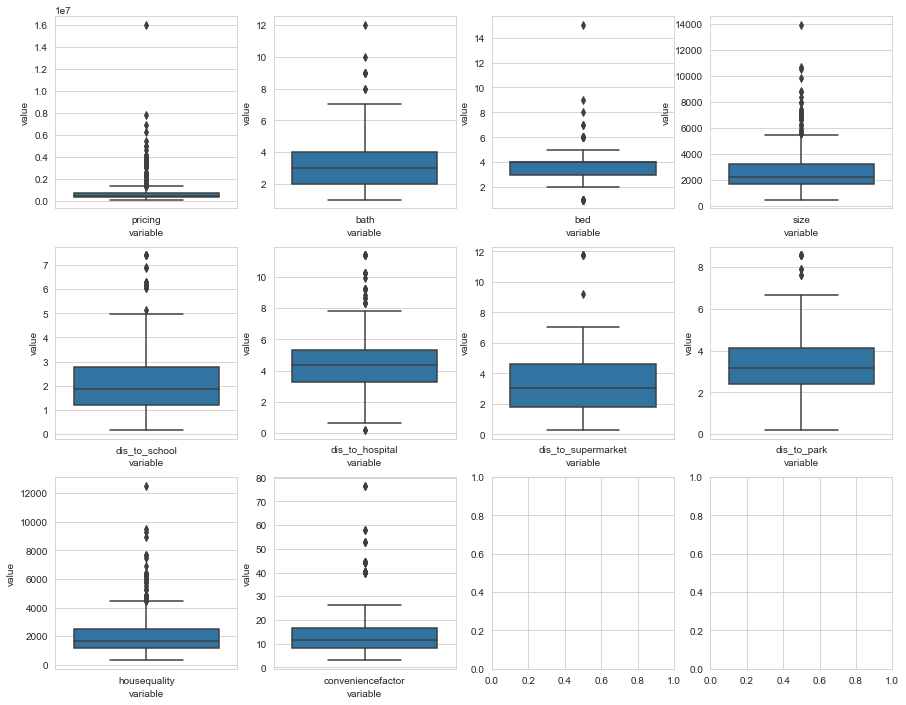

In [31]:
# checking how features look like before outlier removal 

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(3,4, figsize=(15,12))
axes = ax.ravel()
for id, col in enumerate(numericalcols):
    sns.boxplot(x="variable", y="value", data=pd.melt(feature_df_imp[[col]]), ax=axes[id])
plt.show()

In [32]:
def find_outliers_IQR(df):
    """
    This function removes the outlier and returns the dataframe without the outliers
    
        Parameters
        ----------
        df: pd.DataFrame
        a pandas dataframe containing features

        Returns
        -------
        df: pd.DataFrame
        a pandas dataframe with outliers removed (shown below)
                    
    """
    
    q1=df.quantile(0.30)
    q3=df.quantile(0.70)
    IQR=q3-q1
    df_cleaned = df[((df>(q1-1.5*IQR)) & (df<(q3+1.5*IQR)))]
    df_cleaned = df_cleaned.dropna()    
    return df_cleaned

In [33]:
# removing outliers from a column (only numerical columns) at time 
feature_df_clean = feature_df_imp.copy()
for col in numericalcols:
    df = find_outliers_IQR(feature_df_clean[[col]])
    feature_df_clean = feature_df_clean.iloc[df.index, :].reset_index(drop=True)
    
feature_df_clean
    

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park,isPool,isBackyard,isGarage,housequality,conveniencefactor
0,359000,2,4,1934,1.57,3.379833,2.46,1.57,False,False,False,1326,14.739122
1,255000,2,2,1175,2.12,4.610000,2.81,5.03,False,False,False,831,9.605039
2,240000,1,2,712,1.21,4.750000,1.42,2.11,False,False,False,408,18.785913
3,650000,2,3,2124,2.81,5.130000,4.55,3.17,False,False,True,1648,7.853494
4,212999,2,4,1580,1.22,5.150000,4.76,3.49,False,False,False,972,9.320646
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,600000,1,3,1499,1.06,4.140000,5.81,3.27,False,False,False,1063,9.457033
346,389000,2,3,1892,2.66,4.190000,5.03,3.11,False,False,False,1416,7.734348
347,599000,3,2,1796,2.38,4.250000,2.44,4.74,False,False,False,1412,10.396401
348,979900,3,4,3359,1.18,4.370000,1.96,1.84,False,True,True,2711,16.358588


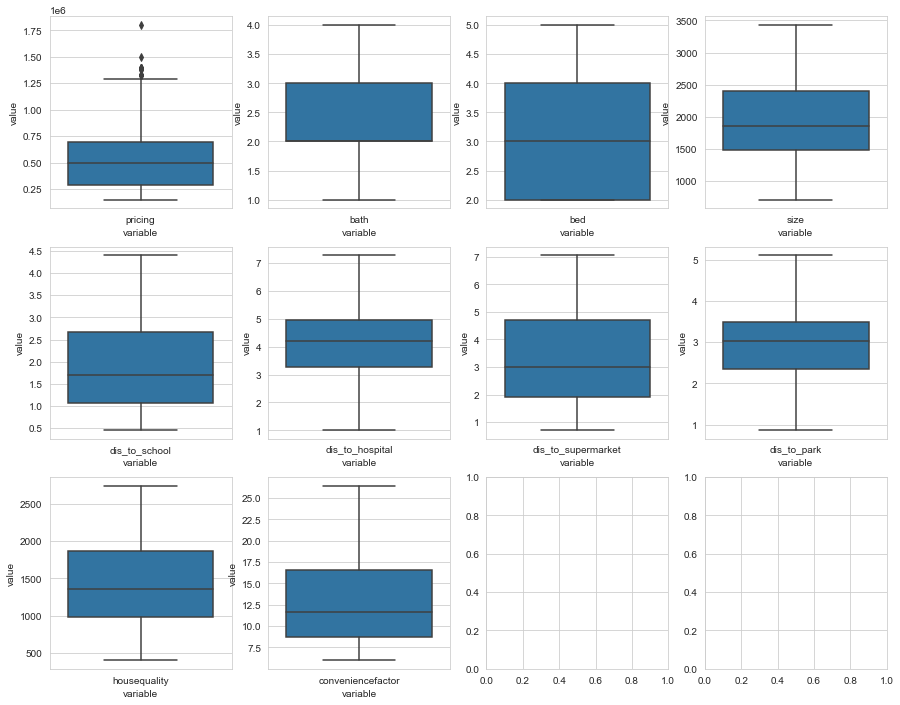

In [34]:
# checking how features look like after outlier removal 

fig, ax = plt.subplots(3,4, figsize=(15,12))
axes = ax.ravel()
for id, col in enumerate(numericalcols):
    sns.boxplot(x="variable", y="value", data=pd.melt(feature_df_clean[[col]]), ax=axes[id])
plt.show()

In [35]:
# saving the boxplot
fig.savefig('boxplot.png')

### Task 3: Label encoding for boolean variables

In [36]:
## Label encoding using LabelEncoder method

label_encoder = LabelEncoder()

for col in boolcols:
    categorical_data = feature_df_clean[[col]]
    label_encoder.fit(categorical_data)
    cat_data=label_encoder.transform(categorical_data)
    feature_df_clean [col] = cat_data


/Users/bishwasapkota/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Task 4: Apply standardization/normalization techniques
It was of an interest to see how standardization and normalization of data impacts regression accuracy. So, both methods were applied for experimentation. Note: scaling was performed for numerical columns pertainig to independent variables. Target variable was not scaled.

In [37]:
def scale_dataframe(scaler, df ):
    """
        This function applies scaler function to the dataframe containing columns of interest
    
        Parameters
        ----------
        scaler: preprocessing.StandardScaler() or preprocessing.MinMaxScaler()
        scaler to apply over columns
        
        df: pd.DataFrame
        a pandas dataframe containing features

        Returns
        -------
        df: pd.DataFrame
        a pandas dataframe with features scaled
        
    """
    scaler.fit(df[numericalcols].drop('pricing', axis=1))
    scaled_X = scaler.transform(df[numericalcols].drop('pricing', axis=1))
    df[Xnumericalcols]= scaled_X
    return df


In [38]:
feature_df_scaled_std= scale_dataframe(preprocessing.StandardScaler(), feature_df_clean )
feature_df_scaled_minmax= scale_dataframe(preprocessing.MinMaxScaler(), feature_df_clean )


In [39]:
feature_df_scaled_minmax.head()

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park,isPool,isBackyard,isGarage,housequality,conveniencefactor
0,359000,0.333333,0.666667,0.450424,0.281726,0.377573,0.274882,0.165094,0,0,0,0.393654,0.426879
1,255000,0.333333,0.000000,0.170660,0.421320,0.574400,0.330174,0.981132,0,0,0,0.181389,0.175478
2,240000,0.000000,0.000000,0.000000,0.190355,0.596800,0.110585,0.292453,0,0,0,0.000000,0.625039
3,650000,0.333333,0.333333,0.520457,0.596447,0.657600,0.605055,0.542453,0,0,1,0.531732,0.089709
4,212999,0.333333,0.666667,0.319941,0.192893,0.660800,0.638231,0.617925,0,0,0,0.241852,0.161552


In [40]:
feature_df_scaled_std.head()

,pricing,bath,bed,size,dis_to_school,dis_to_hospital,dis_to_supermarket,dis_to_park,isPool,isBackyard,isGarage,housequality,conveniencefactor
0,359000,-0.457203,1.219859,0.008489,-0.351942,-0.498327,-0.559510,-1.348141,0,0,0,-0.171178,0.401682
1,255000,-0.457203,-1.299023,-1.054202,0.200165,0.421730,-0.327429,1.954920,0,0,0,-0.962736,-0.632022
2,240000,-1.697675,-1.299023,-1.702457,-0.713321,0.526438,-1.249120,-0.832635,0,0,0,-1.639159,1.216469
3,650000,-0.457203,-0.039582,0.274511,0.892807,0.810645,0.826343,0.179286,0,0,1,0.343735,-0.984681
4,212999,-0.457203,1.219859,-0.487154,-0.703282,0.825603,0.965591,0.484771,0,0,0,-0.737262,-0.689282


# Step 4: Feauture engineering
In this step, two important tasks were carried out
* Task 1: Split the dataset into training and validation
* Task 2: Feature selection using two approaches (mutual-information regression & extratreeclassifier-based feature importance method)


### Task 1: Split the dataset into training and validation

In [41]:
def split_dataset(feature_df_clean):
    """
        This function splits the dataset into training and test dataset. Here, 0.30 is used for the threshold
    
        Parameters
        ----------
        
        feature_df_clean: pd.DataFrame
        a pandas dataframe containing features

        Returns
        -------
        X_train:pd.DataFrame
        Independent variable from training dataset
        
        X_test:pd.DataFrame
        Independent variable from test dataset
        
        y_train:pd.DataFrame
        Target variable from training dataset
        
        y_test:pd.DataFrame
        Target variable from test dataset
       
    """
    
    X = feature_df_clean[Xnumericalcols + boolcols]
    y = feature_df_clean[['pricing']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test

### Task 2: Feature selection

In [42]:
def select_feat_MIC(X_train, y_train):
    
    """
        This function returns best 5 features based on scores it calculates during the process using 
        mutual_regression_function. The function relies on nonparametric methods based on entropy estimation 
        from k-nearest neighbors distances. 
        For more info: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html
        
    
        Parameters
        ----------
        X_train: pd.DataFrame
        Independent variables from training dataset
        
        y_train: pd.DataFrame
        Target variable from training dataset


        Returns
        -------
        index: list
        list of column indices for best 5 features
        
    """

    fsmic = SelectKBest(score_func=mutual_info_regression, k='all')
    fsmic.fit(X_train, y_train)
    X_train_fs = fsmic.transform(X_train)

    for i in range(len(fsmic.scores_)):
        print('Feature %d: %f' % (i, fsmic.scores_[i]))

    plt.bar([i for i in range(len(fsmic.scores_))], fsmic.scores_)
    plt.show()
    return [i for i, e in enumerate(list(fsmic.scores_)) if e in list(np.sort(fsmic.scores_, )[-5:])]

In [43]:
def select_feat_ETC(X_train,y_train):
        
    """
        This function returns best 5 features based on scores it calculates during the process using 
        ExtraTreesClassifier method. The function implements a meta estimator that fits a number of 
        randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses 
        averaging to improve the predictive accuracy and control over-fitting.
        For more info: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
        
    
        Parameters
        ----------
        X_train: pd.DataFrame
        Independent variables from training dataset
        
        y_train: pd.DataFrame
        Target variable from training dataset


        Returns
        -------
        index: list
        list of column indices for best 5 features
        
    """
    
    model = ExtraTreesClassifier()
    model.fit(X_train,y_train)
    print(model.feature_importances_) 
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(5).plot(kind='barh')
    plt.show()
    return [i for i, e in enumerate(X_train.columns) if e in feat_importances.nlargest(5).index]
    

Feature 0: 0.654884
Feature 1: 0.606424
Feature 2: 2.032387
Feature 3: 1.700245
Feature 4: 1.743458
Feature 5: 1.683192
Feature 6: 1.684736
Feature 7: 2.078363
Feature 8: 1.668418
Feature 9: 0.002154
Feature 10: 0.220966
Feature 11: 0.423186


/Users/bishwasapkota/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


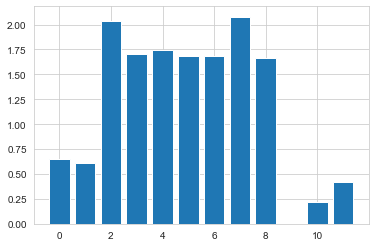

/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/159955887.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


[0.07415474 0.06856452 0.13787824 0.11328643 0.10391852 0.11905007
 0.11063361 0.12603725 0.10706642 0.         0.01535569 0.02405451]


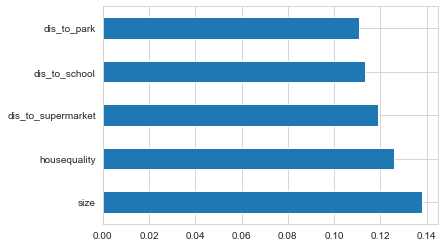

Feature 0: 0.693376
Feature 1: 0.595919
Feature 2: 2.032639
Feature 3: 1.688996
Feature 4: 1.708543
Feature 5: 1.711854
Feature 6: 1.693315
Feature 7: 2.069601
Feature 8: 1.680784
Feature 9: 0.038615
Feature 10: 0.240871
Feature 11: 0.467495


/Users/bishwasapkota/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


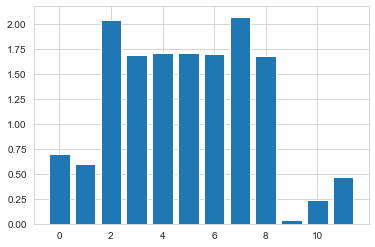

/var/folders/x0/2h7zys993rlcmhbbqwvmlv_80000gn/T/ipykernel_46485/159955887.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


[0.0738266  0.07303783 0.13750633 0.10976952 0.10175339 0.11332044
 0.10877245 0.12722853 0.11530967 0.         0.01433935 0.02513588]


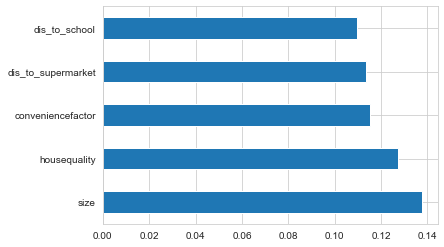

mic_minmax: [2, 3, 4, 6, 7]
etc_minmax: [2, 3, 5, 6, 7]
mic_std: [2, 4, 5, 6, 7]
etc_std: [2, 3, 5, 7, 8]


In [44]:
# implementing the 'select_feat_mic' and 'select_feat_etc'
mic_minmax = select_feat_MIC(split_dataset(feature_df_scaled_minmax)[0], 
                            split_dataset(feature_df_scaled_minmax)[2])

etc_minmax = select_feat_ETC(split_dataset(feature_df_scaled_minmax)[0], split_dataset(feature_df_scaled_minmax)[2])

mic_std = select_feat_MIC(split_dataset(feature_df_scaled_std)[0],
                            split_dataset(feature_df_scaled_std)[2])
etc_std = select_feat_ETC(split_dataset(feature_df_scaled_std)[0], split_dataset(feature_df_scaled_std)[2])


print(f"mic_minmax: {mic_minmax}")
print(f"etc_minmax: {etc_minmax}")

print(f"mic_std: {mic_std}")
print(f"etc_std: {etc_std}")

In [45]:
## Which features were selcted with which scheme ??:

for feat, name in zip([mic_minmax, etc_minmax, mic_std, etc_std], ['mic_minmax', 'etc_minmax', 'mic_std', 'etc_std']):
    data = split_dataset(feature_df_scaled_minmax)[0].iloc[0, feat]
    featlist=data.index.tolist()
    print(f"features selected with {name}: {featlist}")
    
    


features selected with mic_minmax: ['size', 'dis_to_school', 'dis_to_hospital', 'dis_to_park', 'housequality']
features selected with etc_minmax: ['size', 'dis_to_school', 'dis_to_supermarket', 'dis_to_park', 'housequality']
features selected with mic_std: ['size', 'dis_to_hospital', 'dis_to_supermarket', 'dis_to_park', 'housequality']
features selected with etc_std: ['size', 'dis_to_school', 'dis_to_supermarket', 'housequality', 'conveniencefactor']


# Step 5: Model training and development
In this step, three important tasks were carried out
* Task 1: Hyperparameter tuning and model training
* Task 2: Prediction using the best set of parameters for validation
* Task 3: Visualization of validation accuracy for different models


### Task 1: Hyperparameter tuning and model training
Tuning and training process were experimented for 
* two feature scaling: minmax and standardization process
* three sets of features: All, feat selected using mic, feat selected using etc

Hence, the tuning and training process were run for six schemes altogether (2 scaling * 3 feat selection) separately

gridsearchCV method was used to find the best set of parameters and xgboost was choosen as the regressor

In [46]:
def hyperparameter_tuning(X_train, y_train):
    
    """
        This function uses gridsearchCV method to train on various combinations of parameters and compute scores to assist
        in selecting the best set of parameters. XGBRegressor was used as the regression function
        For more info: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
        
    
        Parameters
        ----------
        X_train: pd.DataFrame
        Independent variables from training dataset
        
        y_train: pd.DataFrame
        Target variable from training dataset


        Returns
        -------
        xgb_grid: model
        a fitted xgboost model (contains models for each of the combinations tested)
        
    """
    
    xgb = XGBRegressor()
    parameters = {'nthread':[4],
                  'objective':['reg:linear'],
                  'learning_rate': [.03, 0.05, .07],
                  'max_depth': [6, 7],
                  'min_child_weight': [5, 7],
                  'subsample': [0.6],
                  'colsample_bytree': [0.6, 0.7],
                  'n_estimators': [100,300,500]}

    xgb_grid = GridSearchCV(xgb,
                            parameters,
                            cv = 2,
                            n_jobs = 7, 
                            verbose=True)

    xgb_grid.fit(X_train, y_train)
    return xgb_grid

In [47]:
print('Using MinMaxScaled data')

# all features with minmax scaled
xgb_grid_all_minmax = hyperparameter_tuning(split_dataset(feature_df_scaled_minmax)[0], 
                                     split_dataset(feature_df_scaled_minmax)[2])

# features selected using mutual information on minmax scaled data
xgb_grid_mic_minmax = hyperparameter_tuning(split_dataset(feature_df_scaled_minmax)[0].iloc[:, mic_minmax], 
                                     split_dataset(feature_df_scaled_minmax)[2])

# features selected using extratreeclassifier on minmax scaled data
xgb_grid_etc_minmax = hyperparameter_tuning(split_dataset(feature_df_scaled_minmax)[0].iloc[:, etc_minmax], 
                                     split_dataset(feature_df_scaled_minmax)[2])


Using MinMaxScaled data
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[16:14:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[16:14:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[16:14:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [48]:
print('best score and params when used all vars')
print(xgb_grid_all_minmax.best_score_)
print(xgb_grid_all_minmax.best_params_)

print('best score and params for mutual info-based vars')
print(xgb_grid_mic_minmax.best_score_)
print(xgb_grid_mic_minmax.best_params_)

print('best score and params for extratreeclassifier-based vars')
print(xgb_grid_etc_minmax.best_score_)
print(xgb_grid_etc_minmax.best_params_)


best score and params when used all vars
0.7671146311853845
{'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.6}
best score and params for mic-based vars
0.7766995837495747
{'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.6}
best score and params for featimp-based vars
0.7511885932805888
{'colsample_bytree': 0.6, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 300, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.6}


In [49]:
print('Using standardized data')

# all features with standarized 
xgb_grid_all_std = hyperparameter_tuning(split_dataset(feature_df_scaled_std)[0], 
                                     split_dataset(feature_df_scaled_std)[2])

# features selected using mutual information on standardized data
xgb_grid_mic_std = hyperparameter_tuning(split_dataset(feature_df_scaled_std)[0].iloc[:, mic_std], 
                                     split_dataset(feature_df_scaled_std)[2])

# features selected using extratreeclassifier on standardized data

xgb_grid_etc_std = hyperparameter_tuning(split_dataset(feature_df_scaled_std)[0].iloc[:, etc_std], 
                                     split_dataset(feature_df_scaled_std)[2])

Using standardized data
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[16:14:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[16:15:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 2 folds for each of 72 candidates, totalling 144 fits
[16:15:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:13:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_o

In [50]:
print('best score and params when used all vars')
print(xgb_grid_all_std.best_score_)
print(xgb_grid_all_std.best_params_)

print('best score and params for mutual info-based vars')
print(xgb_grid_mic_std.best_score_)
print(xgb_grid_mic_std.best_params_)

print('best score and params for extratreeclassifier-based vars')
print(xgb_grid_etc_std.best_score_)
print(xgb_grid_etc_std.best_params_)


best score and params when used all vars
0.768049490000126
{'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.6}
best score and params for mutual info-based vars
0.7762417926493155
{'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 300, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.6}
best score and params for extratreeclassifier-based vars
0.7543792310173036
{'colsample_bytree': 0.6, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 300, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.6}


### Task 2: Prediction using the best set of parameters for validation

Earlier, 6 sets of best parameters (2 scaling * 3 feature selection schemes) were derived. 

It was important to test these 6 models over test data to determine which model could be of our interest for production.

RMSE values were calculated using model predicted values and actual values (y_train)


In [51]:
def calculate_rmse(predict):
    """
        This function calculates RMSE values using predicted and actual values
    
        Parameters
        ----------
        predict: numpy.ndarray

        Returns
        -------
        score: float
        rmse score value
        
    """

    actual = np.array(split_dataset(feature_df_scaled_minmax)[3]).flatten() # actual value is same for all scheme test
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

In [52]:
# pred using minmax-based models
pred_all_minmax= xgb_grid_all_minmax.best_estimator_.predict(split_dataset(feature_df_scaled_minmax)[1])
pred_mic_minmax= xgb_grid_mic_minmax.best_estimator_.predict(split_dataset(feature_df_scaled_minmax)[1].iloc[:, mic_minmax])
pred_etc_minmax= xgb_grid_etc_minmax.best_estimator_.predict(split_dataset(feature_df_scaled_minmax)[1].iloc[:, etc_minmax])


# pred using std-based models
pred_all_std= xgb_grid_all_std.best_estimator_.predict(split_dataset(feature_df_scaled_std)[1])
pred_mic_std= xgb_grid_mic_std.best_estimator_.predict(split_dataset(feature_df_scaled_std)[1].iloc[:, mic_std])
pred_etc_std= xgb_grid_etc_std.best_estimator_.predict(split_dataset(feature_df_scaled_std)[1].iloc[:, etc_std])

# listing the predictions from all 6 schemes
predlist= [pred_all_minmax, pred_mic_minmax, pred_etc_minmax, pred_all_std, pred_mic_std, pred_etc_std]

# calculating rmse values for each of the prediction set
rmselist=[calculate_rmse(pred) for pred in predlist]

# calculating normalized rmse values for each of the prediction set (normalized rmse = rmse / mean(actual values))
nrmselist = [round((rmse/np.array(split_dataset(feature_df_scaled_minmax)[3]).flatten().mean()), 3) for rmse in rmselist]

# creating a pandas dataframe to store rmse values for different model schemes
RMSEtable = pd.DataFrame(columns=['scaling_scheme', 'featselect_scheme'])

RMSEtable['scaling_scheme'] = ['minmax_scaler', 'minmax_scaler', 'minmax_scaler', 
                               'standard_scaler', 'standard_scaler', 'standard_scaler'] 

RMSEtable['featselect_scheme'] = ['feature_all', 'feature_mic', 'feature_etc', 
                                  'feature_all', 'feature_mic', 'feature_etc'] 

RMSEtable['RMSE'] = rmselist
RMSEtable['nRMSE'] = nrmselist

RMSEtable

In [53]:
RMSEtable

,scaling_scheme,featselect_scheme,RMSE,nRMSE
0,minmax_scaler,feature_all,47339.580970,0.090
1,minmax_scaler,feature_mic,37647.201910,0.072
2,minmax_scaler,feature_etc,38760.653789,0.074
3,standard_scaler,feature_all,47536.891998,0.090
4,standard_scaler,feature_mic,38311.929480,0.073
5,standard_scaler,feature_etc,49014.666389,0.093


### Task 3: Visualization of accuracy metrics for different model

sns barplots are generated to visualize rmse and nrmse values for 6 different schemes

/Users/bishwasapkota/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


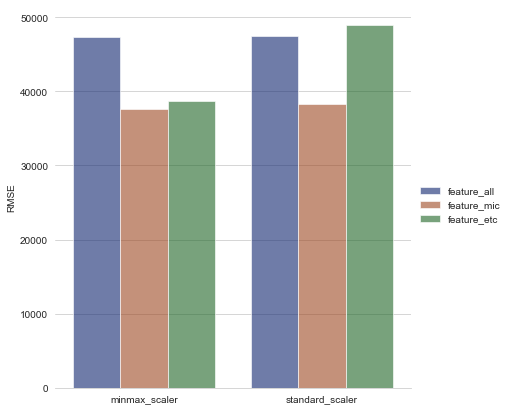

In [54]:
## RMSE

g= sns.catplot(
        data=RMSEtable, kind="bar",
        x="scaling_scheme", y="RMSE", hue="featselect_scheme",
     palette="dark", alpha=.6, height=6, ax=ax[i]
    )

g.despine(left=True)
g.set_axis_labels("", "RMSE")
g.legend.set_title("")


In [55]:
# saving barchart to be used later for dispaly in the web-app 
fig=g.fig
fig.savefig('rmse.png')


/Users/bishwasapkota/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


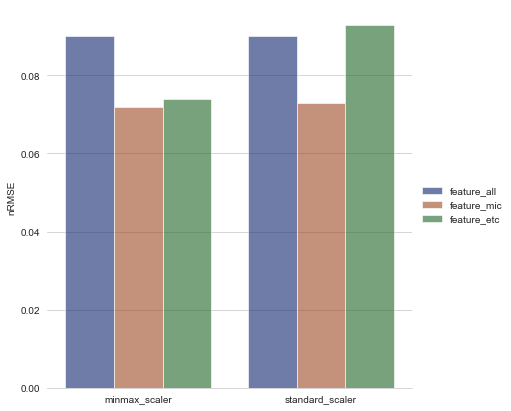

In [56]:
## Normalized RMSE (nRMSE)


g= sns.catplot(
        data=RMSEtable, kind="bar",
        x="scaling_scheme", y="nRMSE", hue="featselect_scheme",
     palette="dark", alpha=.6, height=6, ax=ax[i]
    )

g.despine(left=True)
g.set_axis_labels("", "nRMSE")
g.legend.set_title("")
sns.set_style("whitegrid")

In [57]:
# saving barchart to be used later for dispaly in the web-app 
fig=g.fig
fig.savefig('nrmse.png')


## Analysis
* The barchart for rmse and nrmse shows both DS schemes resulted in comparable performance. 
* All features resulted in highest rmse and nrmse value for minmax scheme whereas etc-based FS scheme resulted in highest rmse and nrmse values for standardization scheme.

#### In overall, features selected using mutual-info FS scheme from data scaled using minmax DS scheme resulted in lowest rmse and nrmse. This model will be choosen for production
* Best model = xgb_grid_mic_minmax
* Best set of features= ['size', 'dis_to_school', 'dis_to_hospital', 'dis_to_park', 'housequality']

# Preparation for model deployment in cloud

In [58]:
# saving model pertaining to minmax DS scheme with mutual-information FS scheme
pickle.dump(xgb_grid_mic_minmax.best_estimator_, open('xgb_best_model.pkl', 'wb'))

In [59]:
# saving minmax scaler object by serealizing it 

## finding the set of columns that yielded in best results
data = split_dataset(feature_df_scaled_minmax)[0].iloc[0, mic_minmax]
data.index.tolist()

['size', 'dis_to_school', 'dis_to_hospital', 'dis_to_park', 'housequality']

In [60]:
## fitting the scaler for only the features that proved to be important and save the scaler
## same dataset that was used during the training is used here
scaler=preprocessing.MinMaxScaler()
scaler.fit(feature_df_clean[data.index.tolist()] )
pickle.dump(scaler, open("minmax_scaler.pkl", 'wb'))

## This is the end of model development process


## Web-app development and deployment
A flask-based webapp is created. Here's a brief layout. You can find more details on the report about the Web-app development and deployment 
* main.py: contains flask app codes and functions to predict the house price from 
        * user-submitted data via form
        * user-submitted json data 
* html and css file: for frontend
* xgb_best_model.pkl file
* minmax_scaler.pkl file

All of the codes are provided in github 

Demonstration of how the deployed model is used to predict on new data is give in the report

API for GUI: http://ec2-3-83-68-187.compute-1.amazonaws.com/

RESTful API: http://ec2-3-83-68-187.compute-1.amazonaws.com/predictapi